#  과제2-1. 수어번역기 모델링 및 추적(개인과제)

## 1.환경준비

### (1) 라이브러리 로딩

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random as rd

from sklearn.model_selection import train_test_split
from sklearn.metrics import *

from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from keras.backend import clear_session
from keras.optimizers import Adam

import mlflow
import mlflow.keras

In [2]:
np.set_printoptions(linewidth=np.inf)

* 함수 만들기

In [3]:
# 학습곡선 함수
def dl_history_plot(history):
    plt.figure(figsize=(10,6))
    plt.plot(history['loss'], label='train_err', marker = '.')
    plt.plot(history['val_loss'], label='val_err', marker = '.')

    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid()
    plt.show()

### (2) 데이터로딩

#### 1) 데이터 가져오기
* 제공 받은 데이터를 여러분의 구글드라이브 적절한 위치에 업로드 합니다.
    * 가능하면, 구글드라이브 첫 경로 밑에 폴더를 만들고 업로드 하기를 권장합니다.

In [10]:
path = 'data/'
file = 'sign_language.csv'

data = pd.read_csv(path+file)
data.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,22,186,186,185,185,185,184,185,184,184,...,171,122,65,62,215,180,99,47,31,25
1,24,175,177,179,181,181,182,182,182,183,...,202,202,201,200,199,197,195,193,191,189
2,6,187,187,187,187,187,186,187,186,186,...,45,23,25,34,41,43,39,40,43,35
3,2,169,169,169,170,169,170,169,169,169,...,204,203,200,199,198,196,194,193,191,190
4,21,153,165,170,179,190,198,203,206,213,...,161,122,132,96,75,63,37,43,70,66


In [11]:
data.shape

(8000, 785)

#### 2) class names
* label이 0 ~ 27 까지의 숫자로 표현됩니다.
* 수어 중에서 J(9) 와 Z(27)는 손을 움직이면서 표현해야 하므로, 여기서는 제외합니다.
* 숫자로 레이블링 된 것을, 나중에 문자 변환하기 위해 문자로 된 리스트를 생성합니다.

In [12]:
import string
class_names = list(string.ascii_lowercase)
class_names = np.array(class_names)
len(class_names), class_names

(26,
 array(['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z'], dtype='<U1'))

### (3) mlflow 추적 준비
* 서버 주소 사용

In [13]:
mlflow_uri = "http://mlflow.carpediem.so"
mlflow.set_tracking_uri(mlflow_uri)

### (4) 새 실험 생성
* 팀에서 1명만 새 실험 생성 
    * exp_## (## : 팀 번호)
    * 팀원들과 exp id 공유

In [14]:
exp_id = '17'

## 2.데이터 준비

### (1) 데이터 분할1 : x, y 나누기

In [37]:
target = 'label'
x = data.drop(target, axis = 1)
y = data.loc[:, target]

### (2) 데이터 분할2 : train, test

* 적절하게 분할 하시오.

In [38]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 1000, random_state = 20)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 2000, random_state = 20)

### (3) DL을 위한 전처리
* 모두 넘파이로 변환

In [39]:
x_train, x_val, x_test = x_train.values, x_val.values, x_test.values
y_train, y_val, y_test = y_train.values, y_val.values, y_test


* shape 맞추기 n, 28,28,1

In [40]:
x_train = x_train.reshape(-1,28,28,1)
x_val = x_val.reshape(-1,28,28,1)
x_test = x_test.reshape(-1,28,28,1)

In [41]:
x_train.shape, x_val.shape, x_test.shape

((5000, 28, 28, 1), (2000, 28, 28, 1), (1000, 28, 28, 1))

* Scaling : Min-Max
    * 0-255 값으로 되어 있는 데이터를 0-1사이 값으로 변환
    * x_train2, x_val2 를 그냥 255로 나누면 됨

In [42]:
x_train = x_train / 255.
x_val = x_val / 255.
x_test = x_test / 255.

## 3.모델링
* 개인별 모델링 및 추적

### (1) 모델 추적

In [46]:
with mlflow.start_run(experiment_id = exp_id, run_name = 'Son'):

    mlflow.keras.autolog()
    model = Sequential([Conv2D(8, kernel_size=3, input_shape=(28, 28, 1), padding='same', strides = 1, activation='relu'),
                    MaxPooling2D(pool_size=2, strides=2),
                    Flatten(),
                    Dense(26, activation='softmax') ])

    model.compile(optimizer= 'adam', loss='sparse_categorical_crossentropy')
    history = model.fit(x_train, y_train, epochs=10, validation_split=.2).history
    
    mlflow.keras.log_model(model, "model",  registered_model_name="Sign_Signal_17_son")
    
    mlflow.keras.autolog(disable = True)

Epoch 1/10
  1/125 [..............................] - ETA: 36s - loss: 3.3161WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0017s vs `on_train_batch_end` time: 0.0053s). Check your callbacks.


125/125 [==============================] - 1s 6ms/step - loss: 2.9659 - val_loss: 2.6002
Epoch 2/10
125/125 [==============================] - 1s 4ms/step - loss: 2.1919 - val_loss: 1.8696
Epoch 3/10
125/125 [==============================] - 1s 4ms/step - loss: 1.5653 - val_loss: 1.3404
Epoch 4/10
125/125 [==============================] - 1s 4ms/step - loss: 1.2215 - val_loss: 1.1016
Epoch 5/10
125/125 [==============================] - 1s 4ms/step - loss: 0.9646 - val_loss: 0.8993
Epoch 6/10
125/125 [==============================] - 1s 5ms/step - loss: 0.7808 - val_loss: 0.7677
Epoch 7/10
125/125 [==============================] - 1s 6ms/step - loss: 0.6537 - val_loss: 0.6418
Epoch 8/10
125/125 [==============================] - 1s 6ms/step - loss: 0.5520 - val_loss: 0.5666
Epoch 9/10
125/125 [==============================] - 1s 6ms/step - loss: 0.4699 - val_loss: 0.5073
Epoch 10/10
125/125 [==============================] - 1s 6ms/step - loss: 0.4069 - val_loss: 0.4658


1/1 [==============================] - 0s 56ms/step


INFO:tensorflow:Assets written to: C:\Users\user\AppData\Local\Temp\tmp09ps1uz9\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\user\AppData\Local\Temp\tmp09ps1uz9\model\data\model\assets
2023/12/04 16:15:31 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: C:\Users\user\AppData\Local\Temp\tmpumgd9tw5\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\user\AppData\Local\Temp\tmpumgd9tw5\model\data\model\assets
Successfully registered model 'Sign_Signal_17_son'.
2023/12/04 16:15:37 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: Sign_Signal_17_son, version 1
Created version '1' of model 'Sign_Signal_17_son'.


* 학습곡선

In [21]:
history = model.fit(X_train_scaled, y_train, epochs=10, validation_data=(X_val_scaled, y_val))


Epoch 1/10
175/175 [==============================] - 3s 14ms/step - loss: 2.9377 - accuracy: 0.1232 - val_loss: 1.9311 - val_accuracy: 0.4013
Epoch 2/10
175/175 [==============================] - 2s 11ms/step - loss: 1.3807 - accuracy: 0.5586 - val_loss: 0.9474 - val_accuracy: 0.6875
Epoch 3/10
175/175 [==============================] - 2s 12ms/step - loss: 0.7774 - accuracy: 0.7461 - val_loss: 0.6528 - val_accuracy: 0.7694
Epoch 4/10
175/175 [==============================] - 2s 13ms/step - loss: 0.4911 - accuracy: 0.8407 - val_loss: 0.3693 - val_accuracy: 0.8800
Epoch 5/10
175/175 [==============================] - 2s 13ms/step - loss: 0.3092 - accuracy: 0.9038 - val_loss: 0.2512 - val_accuracy: 0.9106
Epoch 6/10
175/175 [==============================] - 2s 13ms/step - loss: 0.1993 - accuracy: 0.9362 - val_loss: 0.1737 - val_accuracy: 0.9469
Epoch 7/10
175/175 [==============================] - 2s 13ms/step - loss: 0.1461 - accuracy: 0.9563 - val_loss: 0.1130 - val_accuracy: 0.9694

* 예측 및 검증

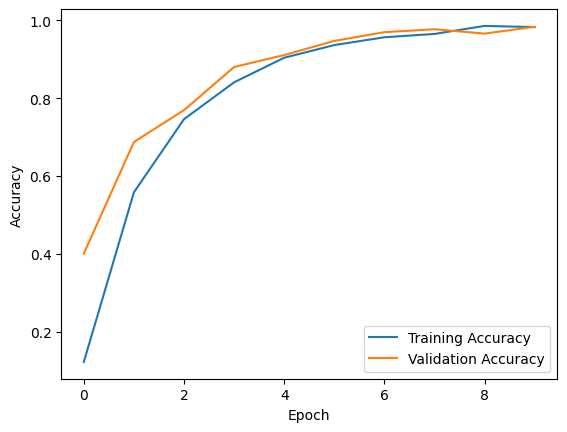

In [22]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

(None, 28, 28, 1)
X_test_scaled Shape: (800, 28, 28, 1)
Model Input Shape after Reshaping: (None, 28, 28, 1)
25/25 [==============================] - 0s 6ms/step - loss: 46.3856 - accuracy: 0.9050
Test Accuracy: 0.9049999713897705
25/25 [==============================] - 0s 5ms/step


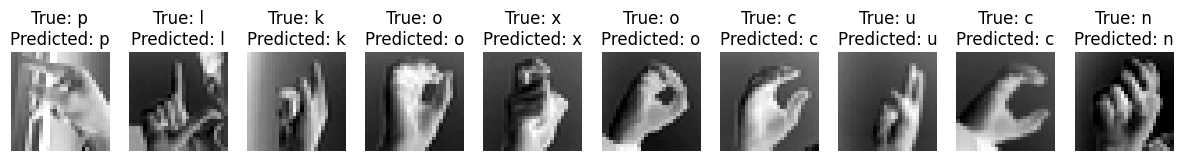

In [23]:
print(model.input_shape)
print("X_test_scaled Shape:", X_test.shape)

X_test_scaled_4D = X_test.reshape(-1, 28, 28, 1)

print("Model Input Shape after Reshaping:", model.input_shape)

test_loss, test_acc = model.evaluate(X_test_scaled_4D, y_test)
print(f"Test Accuracy: {test_acc}")

predictions = model.predict(X_test_scaled_4D)
predicted_labels = np.argmax(predictions, axis=1)

n = 10  
plt.figure(figsize=(15, 3))
for i in range(n):
    plt.subplot(1, n, i + 1)
    plt.imshow(X_test[i].reshape(28, 28), cmap=plt.cm.binary)
    plt.title(f"True: {class_names[y_test[i]]}\nPredicted: {class_names[predicted_labels[i]]}")
    plt.axis('off')
plt.show()


## 4.모델 사용하기
* 팀에서 1명만 mlflow server ui에 접속하여 
    * model_## 의 각 버전 중 성능이 가장 좋은 버전을 production으로 상태변경
* 팀원들은 각자 운영모델 로딩하고, 사용해보기
    * test 셋으로 예측 및 평가
    * test image 하나를 불러와서 예측

### (1) 운영모델 로딩

In [24]:
model_uri = 'models:/Sign_Signal/production'
model_p = mlflow.keras.load_model(model_uri)

### (2) test 데이터로 예측하고 평가

In [26]:
pred = model_p.predict(X_test)
pred_1 = pred.argmax(axis=1)

25/25 [==============================] - 0s 2ms/step


In [27]:
print(accuracy_score(y_test, pred_1))
print('-'*60)
print(confusion_matrix(y_test, pred_1))
print('-'*60)
print(classification_report(class_names[y_test], class_names[pred_1]))

0.7125
------------------------------------------------------------
[[28  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  2]
 [ 0 21  0  0  0  0  0  0  2  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0]
 [ 0  0 28  0  0  1  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  2  0]
 [ 0  0  0  8  0  1  0  0  0  0  0  3  0  0  0  0  1  0  0  0  0  3 15  7]
 [ 6  0  0  0 17  0  0  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 26  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  4  0]
 [ 0  0  0  0  0  2 16  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  7  0]
 [ 0  0  0  0  0  0  0 33  0  0  0  0  0  0  0  0  0  0  0  0  0  0  2  0]
 [ 1  0  0  0  0  0  0  0 34  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 26  0  0  0  0  0  0  0  0  0  0  0  0  2  4]
 [ 0  0  0  0  0  0  0  0  0  0 30  0  0  0  0  0  0  0  0  0  0  0 10  0]
 [ 6  0  0  0  0  0  0  0  0  0  0 34  0  0  0  0  0  0  0  0  0  0  0  2]
 [10  0  0  0  0  1  0  0  1  0 

c:\Users\user\anaconda3\envs\ml-pipeline\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\user\anaconda3\envs\ml-pipeline\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\user\anaconda3\envs\ml-pipeline\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### (2) 이미지 로딩해서 사용하기
* 과제1 코드 참조

In [28]:
# 파이프라인에서 필요한 라이브러리/함수
import pandas as pd
import numpy as np
import cv2
import joblib

In [29]:
# 파일 열기
path = 'test image/'
file = 'v.png'
filename = path + file
img = cv2.imread(filename , cv2.IMREAD_GRAYSCALE)

# 크기 조절하기
img = cv2.resize(img, (28, 28))

# 입력데이터 형식을 갖추기
test_sign = img.reshape(1,28,28,1)

test_sign = test_sign / 255.

pred = model_p.predict(test_sign)
pred_1 = pred.argmax(axis=1)
print(class_names[pred_1])

1/1 [==============================] - 0s 44ms/step
['v']
